In [11]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, UTC
session = boto3.Session(profile_name='css-lab1')
client = session.client("cloudwatch", region_name="us-east-1")

In [28]:
from gradio_app.cw_metrics import get_plots
get_plots(client)

[Figure({
     'data': [{'hovertemplate': ('ModelId=amazon.titan-embed-tex' ... '}<br>value=%{y}<extra></extra>'),
               'legendgroup': 'amazon.titan-embed-text-v2:0',
               'line': {'color': '#636efa', 'dash': 'solid'},
               'marker': {'symbol': 'circle'},
               'mode': 'lines',
               'name': 'amazon.titan-embed-text-v2:0',
               'orientation': 'v',
               'showlegend': True,
               'type': 'scatter',
               'x': array([datetime.datetime(2024, 8, 16, 15, 13, tzinfo=tzutc()),
                           datetime.datetime(2024, 8, 16, 15, 18, tzinfo=tzutc()),
                           datetime.datetime(2024, 8, 16, 16, 53, tzinfo=tzutc()),
                           datetime.datetime(2024, 8, 16, 16, 58, tzinfo=tzutc()),
                           datetime.datetime(2024, 8, 16, 18, 18, tzinfo=tzutc()),
                           datetime.datetime(2024, 8, 16, 18, 23, tzinfo=tzutc()),
                         

In [26]:
# Get the metrics for Bedrock
namespace = 'AWS/Bedrock'
all_metrics = client.list_metrics(Namespace=namespace).get('Metrics')
metric_names = set(map(lambda m: m.get('MetricName'), all_metrics))
dimensions = list(map(lambda m: m.get('Dimensions'), all_metrics))
model_ids = set(map(lambda d: d[0].get("Value") if d else None, dimensions))
model_ids.remove(None)

/var/folders/07/qnbc46_s6l3_3mynxfcqp6dw0000gn/T/ipykernel_56834/2214898866.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, df])
/var/folders/07/qnbc46_s6l3_3mynxfcqp6dw0000gn/T/ipykernel_56834/2214898866.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, df])
/var/folders/07/qnbc46_s6l3_3mynxfcqp6dw0000gn/T/ipykernel_56834/2214898866.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

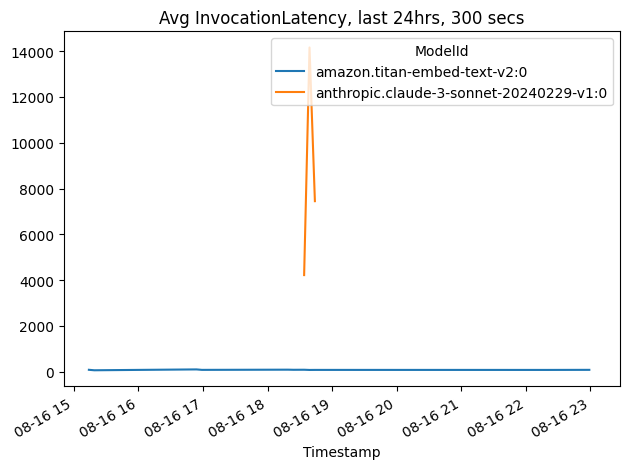

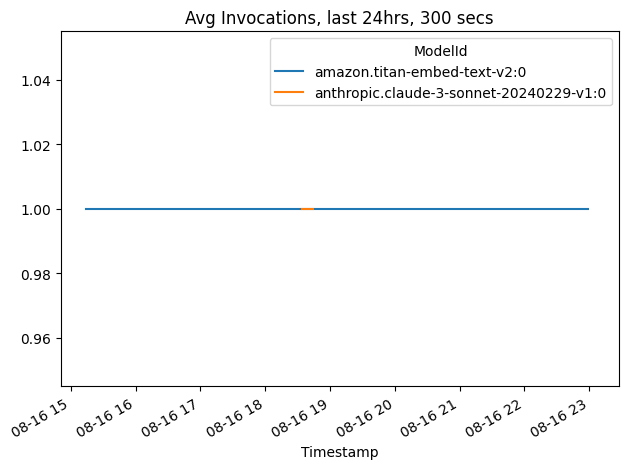

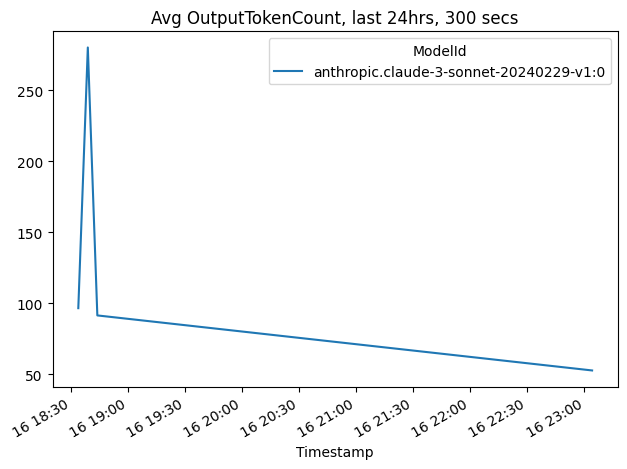

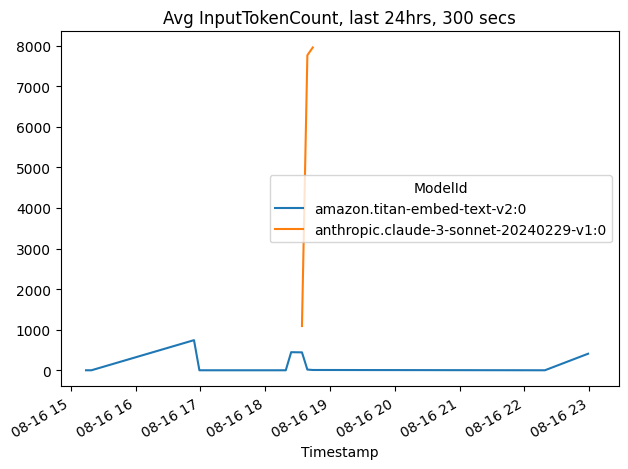

In [27]:
hours = 24
start_time = datetime.now(UTC) - timedelta(hours=hours)
end_time = datetime.now(UTC)
period = 300  # the granularity of the data in seconds (e.g., 300 seconds = 5 minutes)

# Loop through all ModelIds and retrieve their metrics
for metric_name in metric_names:
    metrics_df = pd.DataFrame()
    for model_id in model_ids:
        model_name_id = model_id.replace("-", "_").replace(":", "").replace(".", "_").replace("/", "_")
        start_time = datetime.utcnow() - timedelta(days=1)

        response = client.get_metric_data(
            MetricDataQueries=[
                {
                    "Id": f"m1_{model_name_id}",
                    "MetricStat": {
                        "Metric": {
                            "Namespace": namespace,
                            "MetricName": metric_name,
                            "Dimensions": [
                                {"Name": "ModelId", "Value": model_id},
                            ],
                        },
                        "Period": period,
                        "Stat": "Average",  # You can use 'Sum', 'Maximum', 'Minimum', etc. depending on the metric
                    },
                    "ReturnData": True,
                },
            ],
            StartTime=start_time,
            EndTime=end_time,
        )

        # Extract the relevant data
        timestamps = response["MetricDataResults"][0]["Timestamps"]
        values = response["MetricDataResults"][0]["Values"]

        # Convert to a DataFrame
        df = pd.DataFrame(
            {
                "Timestamp": timestamps,
                "ModelId": model_id,
                "Metric": metric_name,
                "Value": values,
            }
        )

        # Append to the overall DataFrame
        metrics_df = pd.concat([metrics_df, df])

    metrics_df["ModelId"] = metrics_df["ModelId"].apply(lambda x: x.split("/")[-1])  # Remove the arn prefix
    pivot_df = metrics_df.pivot(index=["Timestamp"], columns="ModelId", values="Value")
    ax = pivot_df.plot(kind="line", title=f"Avg {metric_name}, last {hours}hrs, {period} secs")
    plt.tight_layout()